# Importing the libraries

In [1]:
# Import the libraries
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import random
import umap

# Specify the local path where the QuickDraw folder is stored
path = '/home/mapacheroja/Desktop/Tarea1/QuickDraw-10/';

# Load mapping.txt, train.txt and test.txt files
mapping_file = os.path.join(path, 'mapping.txt')
with open(mapping_file, 'r') as f:
  mapping = {line.split()[0]: int(line.split()[1]) for line in f.readlines()}

train_file = os.path.join(path, 'train.txt')
with open(train_file, 'r') as f:
  train_data = [line.strip().split() for line in f.readlines()]

test_file = os.path.join(path, 'test.txt')
with open(test_file, 'r') as f:
  test_data = [line.strip().split() for line in f.readlines()]

# Print sample of train and test data
print(f"Train Data Sample: {train_data[:5]}")
print(f"Test Data Sample: {test_data[:5]}")

Train Data Sample: [['images/sink/262_00048051.jpg', '0'], ['images/sink/262_00202339.jpg', '0'], ['images/sink/262_00043468.jpg', '0'], ['images/sink/262_00119722.jpg', '0'], ['images/sink/262_00072354.jpg', '0']]
Test Data Sample: [['images/sink/262_00143983.jpg', '0'], ['images/sink/262_00082171.jpg', '0'], ['images/sink/262_00114430.jpg', '0'], ['images/sink/262_00107634.jpg', '0'], ['images/sink/262_00119974.jpg', '0']]


In [2]:
# Number of samples to randomly select from the training data
num_samples = 1000  

np.random.seed(22)

# Randomly sample the indices of the training data
random_indices = np.random.choice(len(train_data), size=num_samples, replace=False)

# Select the images and labels corresponding to the random indices
train_data_subset = [train_data[i] for i in random_indices]
train_images_subset = [os.path.join(path, item[0]) for item in train_data_subset]
train_labels_subset = [item[1] for item in train_data_subset]

print(f"Subset Train Data Sample: {train_data_subset[:5]}")

Subset Train Data Sample: [['images/spreadsheet/278_00087107.jpg', '6'], ['images/sink/262_00001566.jpg', '0'], ['images/trombone/324_00106886.jpg', '9'], ['images/blackberry/033_00037365.jpg', '5'], ['images/teapot/302_00012847.jpg', '3']]


In [3]:
# Load and preprocess the images
train_images = []
for img_path in train_images_subset:
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 256))  # Ensure size (in case needed)
    img_array = np.array(img).flatten()  # Flatten the 256x256 image into a 65536-length vector
    train_images.append(img_array)

train_images = np.array(train_images)
train_labels = np.array(train_labels_subset, dtype=int)

print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of train_labels: {train_labels.shape}")

# Assuming 'mapping' dictionary has been loaded correctly
# mapping = {'sink': 0, 'castle': 1, 'lion': 2, ..., 'trombone': 9}

# Create a reverse mapping to convert integers back to class names
reverse_mapping = {v: k for k, v in mapping.items()}

# Convert train_labels from integers to class names (strings)
train_labels_strings = [reverse_mapping[label] for label in train_labels]

# Check the result
print(f"Converted train_labels: {train_labels_strings[:5]}")  # Print first 5 labels to verify

# If needed, you can also convert to a numpy array
train_labels_strings = np.array(train_labels_strings)
print(f"Shape of train_labels_strings: {train_labels_strings.shape}")

Shape of train_images: (1000, 65536)
Shape of train_labels: (1000,)
Converted train_labels: ['spreadsheet', 'sink', 'trombone', 'blackberry', 'teapot']
Shape of train_labels_strings: (1000,)


In [4]:
# Prepare test images and labels
test_images = []
test_labels = []

for item in test_data:
    img_path = os.path.join(path, item[0])  # <- no extra 'images' here
    label = item[1]
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 256))
    img_array = np.array(img).flatten()
    test_images.append(img_array)
    test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels, dtype=int)

print(f"Shape of test_images: {test_images.shape}")
print(f"Shape of test_labels: {test_labels.shape}")

# Assuming 'mapping' dictionary has been loaded correctly
# mapping = {'sink': 0, 'castle': 1, 'lion': 2, ..., 'trombone': 9}

# Create a reverse mapping to convert integers back to class names
reverse_mapping = {v: k for k, v in mapping.items()}

# Convert train_labels from integers to class names (strings)
test_labels_strings = [reverse_mapping[label] for label in train_labels]

# Check the result
print(f"Converted test_labels: {test_labels_strings[:5]}")  # Print first 5 labels to verify

# If needed, you can also convert to a numpy array
test_labels_strings = np.array(test_labels_strings)
print(f"Shape of test_labels_strings: {test_labels_strings.shape}")


Shape of test_images: (1166, 65536)
Shape of test_labels: (1166,)
Converted test_labels: ['spreadsheet', 'sink', 'trombone', 'blackberry', 'teapot']
Shape of test_labels_strings: (1000,)


In [5]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

print("Ready")

Ready


In [6]:
# Assuming reverse_mapping dictionary exists to map numeric labels to class names
reverse_mapping = {
    0: 'sink',
    1: 'castle',
    2: 'lion',
    3: 'teapot',
    4: 'flashlight',
    5: 'blackberry',
    6: 'spreadsheet',
    7: 'bandage',
    8: 'remote-control',
    9: 'trombone'
}

def plot_accuracy_per_class(class_names, accuracies, model_name):
    plt.figure(figsize=(10, 6))
    plt.barh(class_names, accuracies, color='lightgreen')

    # Add labels and title
    plt.xlabel('Accuracy (Precision)')
    plt.title(f'Accuracy per Class for {model_name}')

     # Set the x-axis limit to 1.0 (maximum accuracy)
    plt.xlim(0, 1.0)

    # Show the plot
    plt.show()

def plot_confusion_matrix_for_model(predictions, y_test, class_names, model_name):
    # Compute confusion matrix from the predictions
    cm = confusion_matrix(y_test, predictions)
    
    # Create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Example usage for a model
class_names = ['sink', 'castle', 'lion', 'teapot', 'flashlight', 'blackberry', 
               'spreadsheet', 'bandage', 'remote-control', 'trombone']

In [7]:
# 1. SVM with RBK Kernel

# Train SVM with RBF kernel and raw image vectors
svm_rbf_raw = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf_raw.fit(train_images_scaled, train_labels)

# Predictions and evaluation
predictions_rbf_raw = svm_rbf_raw.predict(test_images_scaled)
accuracy_rbf_raw = accuracy_score(test_labels, predictions_rbf_raw)

# Convert predictions and test_labels to string labels
predictions_strings = [reverse_mapping[pred] for pred in predictions_rbf_raw]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_rbf_raw = accuracy_score(test_labels_strings, predictions_strings)
print(f"Accuracy with RBF kernel + Raw Vectors (String Labels): {accuracy_rbf_raw:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_strings))

Accuracy with RBF kernel + Raw Vectors (String Labels): 0.5961
                precision    recall  f1-score   support

       bandage       0.78      0.46      0.58       121
    blackberry       0.50      0.66      0.57       103
        castle       0.65      0.60      0.62       122
    flashlight       0.41      0.64      0.50       105
          lion       0.56      0.56      0.56       131
remote-control       0.70      0.85      0.77       130
          sink       0.72      0.51      0.60       120
   spreadsheet       0.62      0.59      0.60       116
        teapot       0.62      0.73      0.67       116
      trombone       0.53      0.32      0.40       102

      accuracy                           0.60      1166
     macro avg       0.61      0.59      0.59      1166
  weighted avg       0.62      0.60      0.59      1166



Per-class accuracy for RBF kernel + Raw Vectors: [0.7777777777777778, 0.5, 0.6517857142857143, 0.40853658536585363, 0.5606060606060606, 0.7006369426751592, 0.7176470588235294, 0.6181818181818182, 0.625, 0.532258064516129]


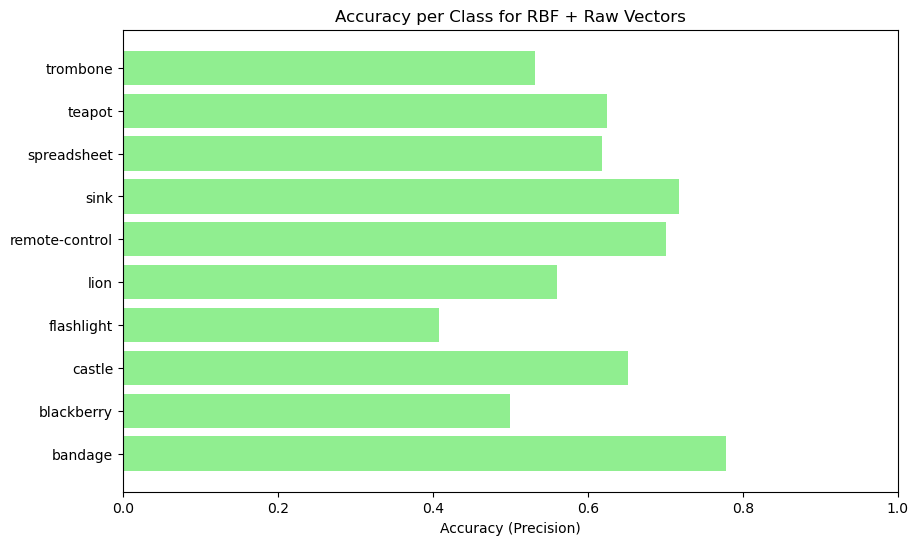

In [8]:
# Get the classification report for the model (replace with your model's predictions)
report_rbf_raw = classification_report(test_labels_strings, predictions_strings, output_dict=True)

# Extract the accuracy (precision) for each class
class_names = list(report_rbf_raw.keys())[:-3]  # Exclude accuracy and avg metrics
accuracies_rbf_raw = [report_rbf_raw[class_name]['precision'] for class_name in class_names]

# Print to verify
print(f"Per-class accuracy for RBF kernel + Raw Vectors: {accuracies_rbf_raw}")

# For RBF + Raw Vectors
plot_accuracy_per_class(class_names, accuracies_rbf_raw, "RBF + Raw Vectors")

<Figure size 800x600 with 0 Axes>

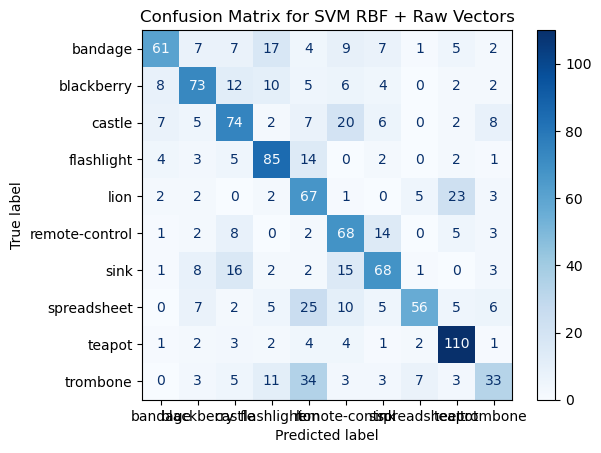

In [9]:
plot_confusion_matrix_for_model(predictions_rbf_raw, test_labels, class_names, "SVM RBF + Raw Vectors")

In [10]:
# Reduce dimensionality with PCA (256 components)
pca = PCA(n_components=256)
train_images_pca = pca.fit_transform(train_images_scaled)
test_images_pca = pca.transform(test_images_scaled)

# Train SVM with RBF kernel on PCA features
svm_rbf_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf_pca.fit(train_images_pca, train_labels)

# Predictions and evaluation
predictions_rbf_pca = svm_rbf_pca.predict(test_images_pca)
accuracy_rbf_pca = accuracy_score(test_labels, predictions_rbf_pca)

# Convert predictions and test_labels to string labels
predictions_rbf_pca_strings = [reverse_mapping[pred] for pred in predictions_rbf_pca]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_rbf_pca = accuracy_score(test_labels_strings, predictions_rbf_pca_strings)
print(f"Accuracy with RBF kernel + PCA (String Labels): {accuracy_rbf_pca:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_rbf_pca_strings))

Accuracy with RBF kernel + PCA (String Labels): 0.5669
                precision    recall  f1-score   support

       bandage       0.82      0.52      0.64       121
    blackberry       0.75      0.52      0.62       103
        castle       0.69      0.56      0.62       122
    flashlight       0.38      0.87      0.53       105
          lion       0.47      0.44      0.45       131
remote-control       0.63      0.85      0.73       130
          sink       0.69      0.54      0.61       120
   spreadsheet       0.67      0.25      0.36       116
        teapot       0.53      0.80      0.63       116
      trombone       0.42      0.29      0.35       102

      accuracy                           0.57      1166
     macro avg       0.61      0.56      0.55      1166
  weighted avg       0.61      0.57      0.56      1166



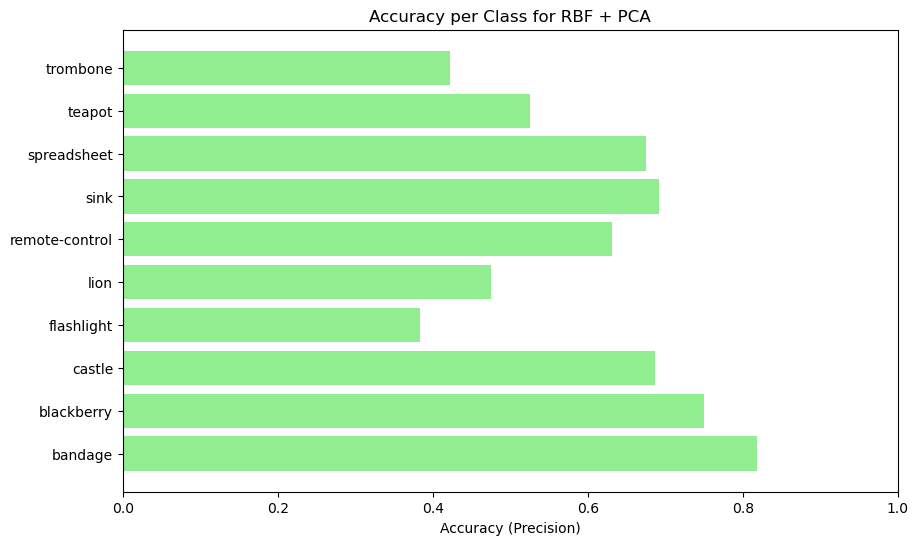

In [11]:
# 2. RBF + PCA
report_rbf_pca = classification_report(test_labels_strings, predictions_rbf_pca_strings, output_dict=True)
accuracies_rbf_pca = [report_rbf_pca[class_name]['precision'] for class_name in class_names]
plot_accuracy_per_class(class_names, accuracies_rbf_pca, "RBF + PCA")

<Figure size 800x600 with 0 Axes>

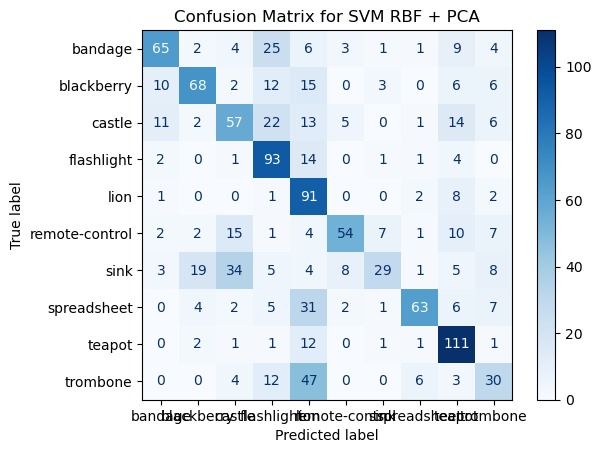

In [12]:
plot_confusion_matrix_for_model(predictions_rbf_pca, test_labels, class_names, "SVM RBF + PCA")

In [13]:
# Reduce dimensionality with UMAP (256 components)
umap_model = umap.UMAP(n_components=256)
train_images_umap = umap_model.fit_transform(train_images_scaled)
test_images_umap = umap_model.transform(test_images_scaled)

# Train SVM with RBF kernel on UMAP features
svm_rbf_umap = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf_umap.fit(train_images_umap, train_labels)

# Predictions and evaluation
predictions_rbf_umap = svm_rbf_umap.predict(test_images_umap)
accuracy_rbf_umap = accuracy_score(test_labels, predictions_rbf_umap)

# Convert predictions and test_labels to string labels
predictions_rbf_umap_strings = [reverse_mapping[pred] for pred in predictions_rbf_umap]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_rbf_umap = accuracy_score(test_labels_strings, predictions_rbf_umap_strings)
print(f"Accuracy with RBF kernel + UMAP (String Labels): {accuracy_rbf_umap:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_rbf_umap_strings))

Accuracy with RBF kernel + UMAP (String Labels): 0.2007
                precision    recall  f1-score   support

       bandage       0.00      0.00      0.00       121
    blackberry       0.12      0.77      0.21       103
        castle       0.00      0.00      0.00       122
    flashlight       0.00      0.00      0.00       105
          lion       0.17      0.50      0.25       131
remote-control       0.62      0.69      0.65       130
          sink       0.00      0.00      0.00       120
   spreadsheet       0.00      0.00      0.00       116
        teapot       0.00      0.00      0.00       116
      trombone       0.00      0.00      0.00       102

      accuracy                           0.20      1166
     macro avg       0.09      0.20      0.11      1166
  weighted avg       0.10      0.20      0.12      1166



/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mapacheroja/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

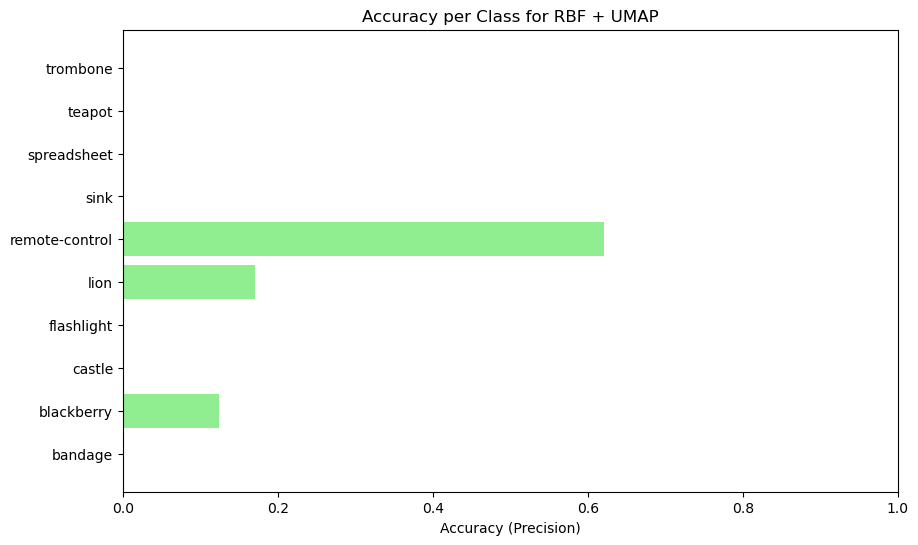

In [14]:
# 3. RBF + UMAP
report_rbf_umap = classification_report(test_labels_strings, predictions_rbf_umap_strings, output_dict=True)
accuracies_rbf_umap = [report_rbf_umap[class_name]['precision'] for class_name in class_names]
plot_accuracy_per_class(class_names, accuracies_rbf_umap, "RBF + UMAP")

<Figure size 800x600 with 0 Axes>

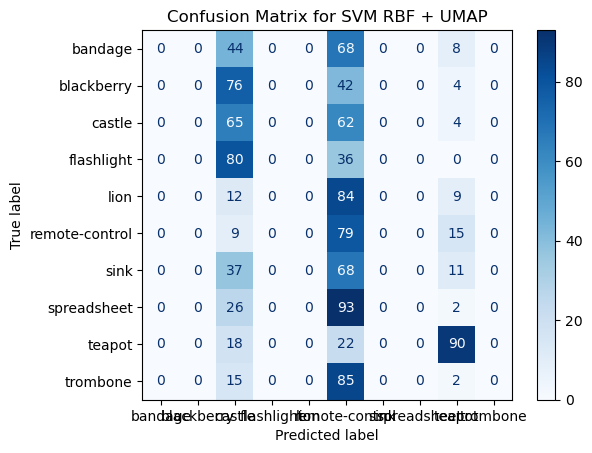

In [15]:
plot_confusion_matrix_for_model(predictions_rbf_umap, test_labels, class_names, "SVM RBF + UMAP")

In [16]:
# Train SVM with Sigmoid kernel and raw image vectors
svm_sigmoid_raw = SVC(kernel='sigmoid', C=1.0)
svm_sigmoid_raw.fit(train_images_scaled, train_labels)

# Predictions and evaluation
predictions_sigmoid_raw = svm_sigmoid_raw.predict(test_images_scaled)
accuracy_sigmoid_raw = accuracy_score(test_labels, predictions_sigmoid_raw)

# Convert predictions and test_labels to string labels
predictions_sigmoid_raw_strings = [reverse_mapping[pred] for pred in predictions_sigmoid_raw]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_sigmoid_raw = accuracy_score(test_labels_strings, predictions_sigmoid_raw_strings)
print(f"Accuracy with Sigmoid kernel + Raw Vectors (String Labels): {accuracy_sigmoid_raw:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_sigmoid_raw_strings))

Accuracy with Sigmoid kernel + Raw Vectors (String Labels): 0.6115
                precision    recall  f1-score   support

       bandage       0.73      0.55      0.63       121
    blackberry       0.60      0.62      0.61       103
        castle       0.63      0.60      0.61       122
    flashlight       0.39      0.66      0.49       105
          lion       0.65      0.54      0.59       131
remote-control       0.70      0.82      0.76       130
          sink       0.64      0.63      0.64       120
   spreadsheet       0.68      0.59      0.63       116
        teapot       0.70      0.75      0.72       116
      trombone       0.46      0.31      0.37       102

      accuracy                           0.61      1166
     macro avg       0.62      0.61      0.60      1166
  weighted avg       0.62      0.61      0.61      1166



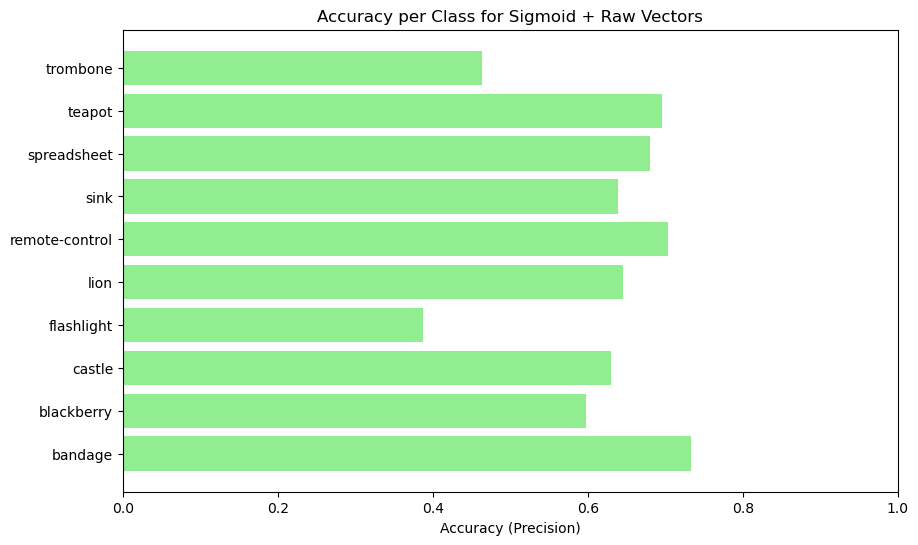

In [17]:
# 4. Sigmoid + Raw Vectors
report_sigmoid_raw = classification_report(test_labels_strings, predictions_sigmoid_raw_strings, output_dict=True)
accuracies_sigmoid_raw = [report_sigmoid_raw[class_name]['precision'] for class_name in class_names]
plot_accuracy_per_class(class_names, accuracies_sigmoid_raw, "Sigmoid + Raw Vectors")


<Figure size 800x600 with 0 Axes>

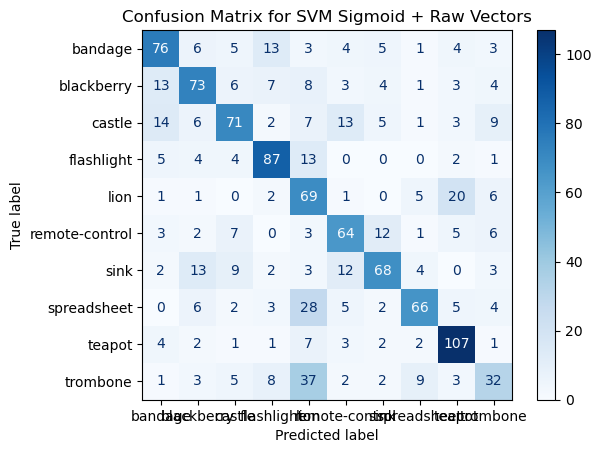

In [18]:
plot_confusion_matrix_for_model(predictions_sigmoid_raw, test_labels, class_names, "SVM Sigmoid + Raw Vectors")

In [19]:
# Train SVM with Sigmoid kernel on PCA features
svm_sigmoid_pca = SVC(kernel='sigmoid', C=1.0)
svm_sigmoid_pca.fit(train_images_pca, train_labels)

# Predictions and evaluation
predictions_sigmoid_pca = svm_sigmoid_pca.predict(test_images_pca)
accuracy_sigmoid_pca = accuracy_score(test_labels, predictions_sigmoid_pca)

# Convert predictions and test_labels to string labels
predictions_sigmoid_pca_strings = [reverse_mapping[pred] for pred in predictions_sigmoid_pca]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_sigmoid_pca = accuracy_score(test_labels_strings, predictions_sigmoid_pca_strings)
print(f"Accuracy with Sigmoid kernel + PCA (String Labels): {accuracy_sigmoid_pca:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_sigmoid_pca_strings))

Accuracy with Sigmoid kernel + PCA (String Labels): 0.6192
                precision    recall  f1-score   support

       bandage       0.74      0.56      0.64       121
    blackberry       0.58      0.60      0.59       103
        castle       0.64      0.64      0.64       122
    flashlight       0.42      0.69      0.52       105
          lion       0.61      0.57      0.59       131
remote-control       0.74      0.82      0.78       130
          sink       0.68      0.62      0.65       120
   spreadsheet       0.62      0.58      0.60       116
        teapot       0.72      0.74      0.73       116
      trombone       0.49      0.32      0.39       102

      accuracy                           0.62      1166
     macro avg       0.62      0.61      0.61      1166
  weighted avg       0.63      0.62      0.62      1166



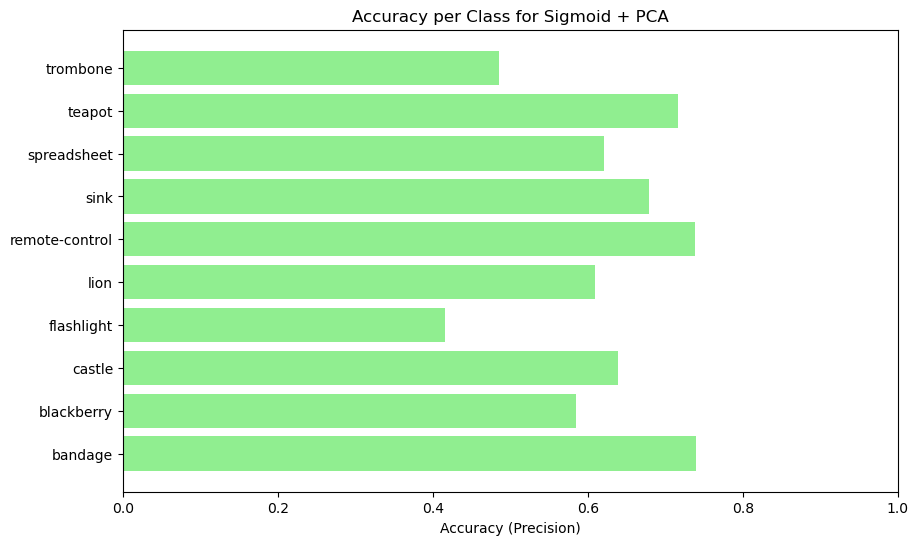

In [20]:
# 5. Sigmoid + PCA
report_sigmoid_pca = classification_report(test_labels_strings, predictions_sigmoid_pca_strings, output_dict=True)
accuracies_sigmoid_pca = [report_sigmoid_pca[class_name]['precision'] for class_name in class_names]
plot_accuracy_per_class(class_names, accuracies_sigmoid_pca, "Sigmoid + PCA")

<Figure size 800x600 with 0 Axes>

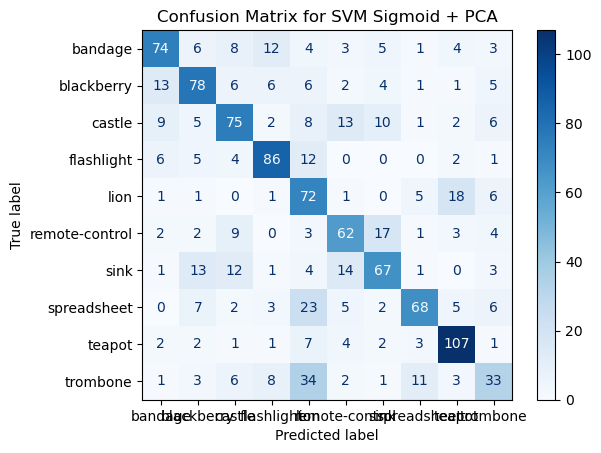

In [21]:
plot_confusion_matrix_for_model(predictions_sigmoid_pca, test_labels, class_names, "SVM Sigmoid + PCA")

In [22]:
# Train SVM with Polynomial kernel on UMAP features
svm_poly_umap = SVC(kernel='poly', degree=3, C=1.0, gamma='scale')  # degree=3 for cubic kernel
svm_poly_umap.fit(train_images_umap, train_labels)

# Predictions and evaluation
predictions_poly_umap = svm_poly_umap.predict(test_images_umap)
accuracy_poly_umap = accuracy_score(test_labels, predictions_poly_umap)

# Convert predictions and test_labels to string labels
predictions_poly_umap_strings = [reverse_mapping[pred] for pred in predictions_poly_umap]
test_labels_strings = [reverse_mapping[label] for label in test_labels]

# Accuracy using string labels
accuracy_poly_umap = accuracy_score(test_labels_strings, predictions_poly_umap_strings)
print(f"Accuracy with Poly kernel + UMAP (String Labels): {accuracy_poly_umap:.4f}")

# Accuracy per class using string labels
print(classification_report(test_labels_strings, predictions_poly_umap_strings))

Accuracy with Poly kernel + UMAP (String Labels): 0.3250
                precision    recall  f1-score   support

       bandage       0.28      0.58      0.38       121
    blackberry       0.31      0.43      0.36       103
        castle       0.31      0.61      0.41       122
    flashlight       0.13      0.11      0.12       105
          lion       0.41      0.05      0.09       131
remote-control       0.73      0.52      0.60       130
          sink       0.26      0.20      0.23       120
   spreadsheet       0.14      0.03      0.06       116
        teapot       0.40      0.36      0.38       116
      trombone       0.32      0.33      0.33       102

      accuracy                           0.33      1166
     macro avg       0.33      0.32      0.30      1166
  weighted avg       0.34      0.33      0.30      1166



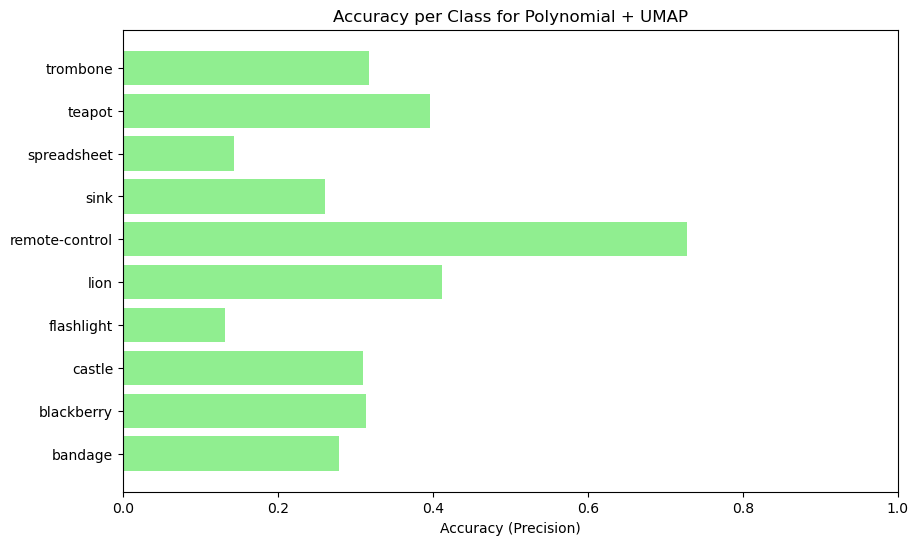

In [23]:
# 6. Polynomial + UMAP
report_poly_umap = classification_report(test_labels_strings, predictions_poly_umap_strings, output_dict=True)
accuracies_poly_umap = [report_poly_umap[class_name]['precision'] for class_name in class_names]
plot_accuracy_per_class(class_names, accuracies_poly_umap, "Polynomial + UMAP")

<Figure size 800x600 with 0 Axes>

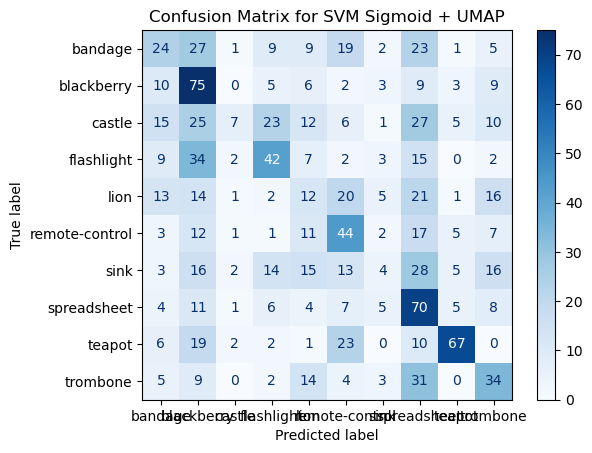

In [24]:
plot_confusion_matrix_for_model(predictions_poly_umap, test_labels, class_names, "SVM Sigmoid + UMAP")

In [25]:
def tune_svm_hyperparameters(X_train, y_train, X_test, y_test, kernel='rbf', param_range=None, cv=5):
    """
    Function to perform hyperparameter tuning using GridSearchCV for SVM models.
    
    Parameters:
    - X_train: Training data features
    - y_train: Training data labels
    - X_test: Test data features
    - y_test: Test data labels
    - kernel: Type of SVM kernel ('rbf', 'linear', 'poly', etc.)
    - param_range: List of values to try for C and gamma
    - cv: Number of cross-validation folds (default 10)

    Returns:
    - Best model after hyperparameter tuning
    - Best hyperparameters
    - Best score
    """
    # Define the hyperparameter grid if it's not provided
    if param_range is None:
        param_range = [0.0001, 0.001]

    param_grid = {
        'C': param_range,
        'gamma': param_range,
    }

    # Create the SVM model with the specified kernel
    model = SVC(kernel=kernel, random_state=42)

    # Create GridSearchCV for hyperparameter tuning
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs=-1  # Use all CPU cores
    )

    # Fit the model to the training data
    gs.fit(X_train, y_train)

    # Print and return the best model and parameters
    print(f"Best Score (accuracy) with {kernel} kernel: {gs.best_score_}")
    print(f"Best Hyperparameters with {kernel} kernel: {gs.best_params_}")

    # Use the best model to predict on the test set
    best_model = gs.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f"Test Accuracy with Best Model: {test_accuracy:.4f}")
    
    return best_model, gs.best_params_, gs.best_score_


In [ ]:
# Raw vectors + RBF kernel
print("\nTuning SVM with RBF kernel on Raw Vectors")
best_model_rbf_raw, best_params_rbf_raw, best_score_rbf_raw = tune_svm_hyperparameters(
    train_images_scaled, train_labels, test_images_scaled, test_labels, kernel='rbf'
)


Tuning SVM with RBF kernel on Raw Vectors


In [14]:
# PCA + RBF kernel
print("\nTuning SVM with RBF kernel on PCA features")
best_model_rbf_pca, best_params_rbf_pca, best_score_rbf_pca = tune_svm_hyperparameters(
    train_images_pca, train_labels, test_images_pca, test_labels, kernel='rbf'
)


Tuning SVM with RBF kernel on PCA features
Best Score (accuracy) with rbf kernel: 0.334
Best Hyperparameters with rbf kernel: {'C': 10.0, 'gamma': 0.0001}
Test Accuracy with Best Model: 0.3714


In [ ]:
# UMAP + RBF kernel
print("\nTuning SVM with RBF kernel on UMAP features")
best_model_rbf_umap, best_params_rbf_umap, best_score_rbf_umap = tune_svm_hyperparameters(
    train_images_umap, train_labels, test_images_umap, test_labels, kernel='rbf'
)

In [ ]:
# Raw vectors + Sigmoid kernel
print("\nTuning SVM with Sigmoid kernel on Raw Vectors")
best_model_sigmoid_raw, best_params_sigmoid_raw, best_score_sigmoid_raw = tune_svm_hyperparameters(
    train_images_scaled, train_labels, test_images_scaled, test_labels, kernel='sigmoid'
)

In [15]:
# PCA + Sigmoid kernel
print("\nTuning SVM with Sigmoid kernel on PCA features")
best_model_sigmoid_pca, best_params_sigmoid_pca, best_score_sigmoid_pca = tune_svm_hyperparameters(
    train_images_pca, train_labels, test_images_pca, test_labels, kernel='sigmoid'
)


Tuning SVM with Sigmoid kernel on PCA features
Best Score (accuracy) with sigmoid kernel: 0.46799999999999997
Best Hyperparameters with sigmoid kernel: {'C': 1.0, 'gamma': 0.0001}
Test Accuracy with Best Model: 0.5060


In [16]:
# UMAP + Polynomial kernel
print("\nTuning SVM with Polynomial kernel on UMAP features")
best_model_poly_umap, best_params_poly_umap, best_score_poly_umap = tune_svm_hyperparameters(
    train_images_umap, train_labels, test_images_umap, test_labels, kernel='poly'
)


Tuning SVM with Polynomial kernel on UMAP features


KeyboardInterrupt: 

In [ ]:
# Example: After training your models, store the accuracies in a dictionary
model_accuracies = {
    'RBF + Raw Vectors': accuracy_rbf_raw,
    'RBF + PCA': accuracy_rbf_pca,
    'RBF + UMAP': accuracy_rbf_umap,
    'Sigmoid + Raw Vectors': accuracy_sigmoid_raw,
    'Sigmoid + PCA': accuracy_sigmoid_pca,
    'Polynomial + UMAP': accuracy_poly_umap
}



In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the model accuracies stored in a dictionary (model_accuracies)
model_names = list(model_accuracies.keys())  # List of model names (x-axis)
accuracies = list(model_accuracies.values())  # List of accuracies (y-axis)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')  # Horizontal bar plot for better readability

# Add labels and title
plt.xlabel('Accuracy')
plt.title('Accuracy of Different SVM Models')

# Show the plot
plt.show()